In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
# from torch.utils import data
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
import torch
import torch.nn as nn
import torch.optim as optim
import random
# from keras.callbacks import EarlyStopping

In [7]:
data = pd.read_csv('combined_data.csv')
data_test = pd.read_csv('2024-testing.csv')

In [8]:
train_data = data
test_data = data_test
print(f"訓練集樣本數: {train_data.shape[0]}")
print(f"測試集樣本數: {test_data.shape[0]}")

訓練集樣本數: 208000
測試集樣本數: 4000


In [9]:
test_data["Material"] = 14
test_data["Condition"] = "unknown"

In [10]:
# 需要標準化的特徵列
feature_columns = [f'y{i:02}' for i in range(1, 11)]

# 使用訓練集來fit標準化
scaler = MinMaxScaler()

# 對訓練集標準化
train_data[feature_columns] = scaler.fit_transform(train_data[feature_columns])

# 對測試數據使用相同的縮放進行標準化
test_data[feature_columns] = scaler.transform(test_data[feature_columns])

In [11]:
def create_sequences(data, feature_columns, window_size_in=50, window_size_out=25):
    sequences = []
    targets = []

    materials = data['Material'].unique()
    conditions = data['Condition'].unique()

    for material in materials:
        for condition in conditions:
            material_condition_data = data[(data['Material'] == material) & (data['Condition'] == condition)]

            # 獲取特徵數據
            features = material_condition_data[feature_columns].values

            # 切割序列
            for i in range(len(features) - window_size_in - window_size_out + 1):
                seq_in = features[i:i+window_size_in]
                seq_out = features[i+window_size_in:i+window_size_in+window_size_out]
                sequences.append(seq_in)
                targets.append(seq_out)

    return np.array(sequences), np.array(targets)

# 創建訓練集的 sequence windows
X_train, y_train = create_sequences(train_data, feature_columns)

# 創建測試集的 sequence windows
X_test, y_test = create_sequences(test_data, feature_columns)

print(f"訓練集序列數: {X_train.shape[0]}")
print(f"測試集序列數: {X_test.shape[0]}")

訓練集序列數: 204152
測試集序列數: 3926


In [17]:
# 設置參數
input_timesteps = 50  # 輸入的時間步
output_timesteps = 25  # 預測的時間步
features = 10  # 每個時間步的特徵數量
latent_dim = 100  # LSTM 層的單元數
dropout_rate = 0.3  # 顯式 Dropout 的機率

# 編碼器
encoder_inputs = Input(shape=(input_timesteps, features))

# 第一層 LSTM，return_sequences=True 以返回整個輸出序列
encoder_lstm_1 = LSTM(latent_dim, return_sequences=True)(encoder_inputs)

# 顯式 Dropout 層，放在第一層編碼器 LSTM 之後
encoder_lstm_1 = Dropout(dropout_rate)(encoder_lstm_1)

# 第二層 LSTM，return_sequences=False 只返回最後的狀態
encoder_lstm_2 = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder_lstm_2(encoder_lstm_1)

# 使用隱藏狀態來初始化解碼器
encoder_states = [state_h, state_c]

# 解碼器
decoder_inputs = RepeatVector(output_timesteps)(state_h)  # 重複隱藏狀態 25 次
decoder_lstm_1 = LSTM(latent_dim, return_sequences=True, return_state=False)
decoder_outputs = decoder_lstm_1(decoder_inputs, initial_state=encoder_states)

# 顯式 Dropout 層，放在第一層解碼器 LSTM 之後
decoder_outputs = Dropout(dropout_rate)(decoder_outputs)

# 在解碼器中加入第二層 LSTM
decoder_lstm_2 = LSTM(latent_dim, return_sequences=True)
decoder_outputs = decoder_lstm_2(decoder_outputs)

# 顯式 Dropout 層，放在第二層解碼器 LSTM 之後
decoder_outputs = Dropout(dropout_rate)(decoder_outputs)

# TimeDistributed 將 Dense 應用於每個時間步
decoder_dense = TimeDistributed(Dense(features))
decoder_outputs = decoder_dense(decoder_outputs)

# 建立模型
model = Model(encoder_inputs, decoder_outputs)
model.compile(optimizer='adam', loss='mean_squared_error')

# 檢查模型結構
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50, 10)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 50, 100)        │         44,400 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50, 100)        │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 100), (None,   │         80,400 │ dropout[0][0]          │
│                           │ 100), (None, 100)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 25, 100)        │              0 │ lstm_1[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 25, 100)        │         80,400 │ repeat_vector[0][0],   │
│                           │                        │                │ lstm_1[0][1],          │
│                           │                        │                │ lstm_1[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 25, 100)        │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 25, 100)        │         80,400 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 25, 100)        │              0 │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 25, 10)         │          1,010 │ dropout_2[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 286,610 (1.09 MB)

 Trainable params: 286,610 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# 訓練參數
batch_size = 64  # 每個批次處理64個樣本
epochs = 27  # 訓練週期

# 模型訓練
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1  # 顯示訓練進度
)

Epoch 1/27
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 50s 14ms/step - loss: 5.7077e-04
Epoch 2/27
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 78s 13ms/step - loss: 1.1039e-04
Epoch 3/27
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 9.9305e-05
Epoch 4/27
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 83s 13ms/step - loss: 9.6882e-05
Epoch 5/27
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - loss: 9.1812e-05
Epoch 6/27
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 9.0673e-05
Epoch 7/27
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - loss: 8.9998e-05
Epoch 8/27
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 80s 13ms/step - loss: 8.7477e-05
Epoch 9/27
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - loss: 8.6692e-05
Epoch 10/27
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 84s 14ms/step - loss: 8.5185e-05
Epoch 11/27
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 80s 13ms/step - loss: 8.4439e-05
Epoch 12/27
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - loss: 8.3599e-05
Epoch 13/27
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 8.2730e-05
Epoch 14/27
3190/3190

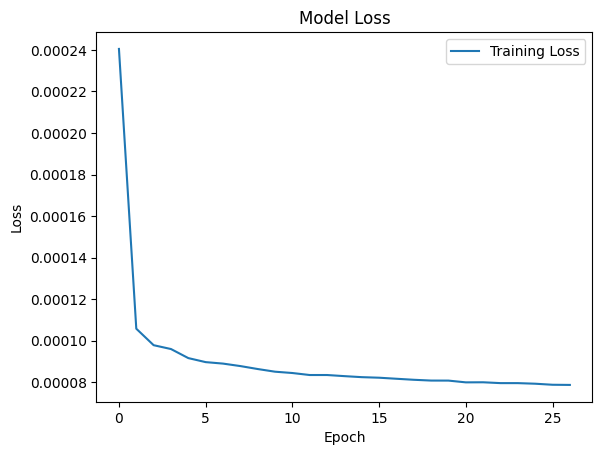

In [19]:
# 繪製訓練損失
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
model.save("Final.keras")

In [21]:
# 開始逐步預測
def stepwise_prediction(model, initial_sequence, prediction_steps=3950, step_size=25):
    predictions = []
    current_input = initial_sequence.reshape(1, 50, 10)  # 保證輸入格式正確

    for _ in range(0, prediction_steps, step_size):
        # 使用模型進行預測
        predicted = model.predict(current_input)
        predictions.append(predicted)

        # 更新輸入，使用最後25筆預測結果加入序列
        current_input = np.concatenate((current_input[:, -25:, :], predicted), axis=1)

    # 將所有預測結果合併為一個大的序列
    return np.concatenate(predictions, axis=1)

In [22]:
# 使用模型進行逐步預測，假設 initial_sequence 是前 50 筆的數據
initial_sequence = X_test[0]  # 測試集中的初始數據
predicted_sequence = stepwise_prediction(model, initial_sequence)
predicted_sequence = predicted_sequence.reshape(-1, 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

In [27]:
predicted_sequence_unscaled = scaler.inverse_transform(predicted_sequence)
predicted_sequence_unscaled

array([[1369.5063 , 1051.413  , 1127.9927 , ..., 1193.9603 , 1215.4907 ,
        1192.7396 ],
       [1392.3329 ,  992.39215, 1076.33   , ..., 1216.4319 , 1245.3608 ,
        1233.6797 ],
       [1408.44   ,  937.3529 , 1026.9053 , ..., 1213.3077 , 1242.6682 ,
        1239.2515 ],
       ...,
       [ 719.3427 ,  719.4092 ,  726.7004 , ...,  724.36334,  721.1606 ,
         719.31946],
       [ 719.2159 ,  719.2791 ,  726.5706 , ...,  724.23535,  721.01996,
         719.2041 ],
       [ 719.10223,  719.16296,  726.45416, ...,  724.12177,  720.89545,
         719.101  ]], dtype=float32)

In [26]:
initial_sequence_scaled = scaler.inverse_transform(initial_sequence)
initial_sequence_scaled

array([[ 989., 1010., 1350., 4095., 2125., 4095., 1237., 1082.,  920.,
        2337.],
       [ 984., 1004., 1340., 4095., 2105., 4095., 1228., 1076.,  916.,
        2314.],
       [ 977.,  997., 1328., 4095., 2084., 4095., 1218., 1068.,  910.,
        2290.],
       [ 971.,  990., 1317., 4095., 2063., 4095., 1209., 1060.,  904.,
        2266.],
       [ 964.,  983., 1306., 4095., 2042., 4095., 1199., 1053.,  898.,
        2243.],
       [ 957.,  976., 1296., 4095., 2021., 4095., 1189., 1045.,  891.,
        2220.],
       [ 951.,  970., 1284., 4095., 2001., 4095., 1179., 1037.,  886.,
        2197.],
       [ 944.,  963., 1274., 4095., 1980., 4095., 1170., 1029.,  880.,
        2160.],
       [ 938.,  956., 1263., 4095., 1961., 4095., 1160., 1022.,  875.,
        2137.],
       [ 931.,  950., 1253., 4095., 1941., 4094., 1151., 1014.,  869.,
        2115.],
       [ 925.,  943., 1243., 4095., 1923., 4046., 1142., 1007.,  864.,
        2093.],
       [ 919.,  937., 1233., 4095., 1904., 

In [28]:
# 將 numpy array 轉換為 pandas DataFrame
df = pd.DataFrame(predicted_sequence_unscaled)

# 將 DataFrame 保存為 CSV 文件
df.to_csv('predicted_sequence_unscaled.csv', index=False)